In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils import benchmark
import pandas as pd
import matplotlib.pyplot as plt

# from condensed_sparsity.models import LinearCondensed

In [17]:
import pickle
result_type = "cpu"
with open(f"../compare_{result_type}.pkl", "rb") as handle:
    compare = pickle.load(handle)
print(compare)

[---------- Linear ----------]
                     |  Linear
48 threads: ------------------
      512    x 2048  |  100.5 
      256    x 2048  |   80.4 
      128    x 2048  |  158.4 
      64     x 2048  |   62.4 
      32     x 2048  |   65.3 
      16     x 2048  |   72.0 
      8      x 2048  |   67.0 
      4      x 2048  |   37.4 
      2      x 2048  |   34.5 
      1      x 2048  |   18.2 

Times are in microseconds (us).

[------------------------------------------------------------------------- Linear Condensed ------------------------------------------------------------------------]
                     |  Linear Condensed @ sparsity 0.5  |  Linear Condensed @ sparsity 0.9  |  Linear Condensed @ sparsity 0.95  |  Linear Condensed @ sparsity 0.99
48 threads: ---------------------------------------------------------------------------------------------------------------------------------------------------------
      512    x 2048  |              795624.3             |       

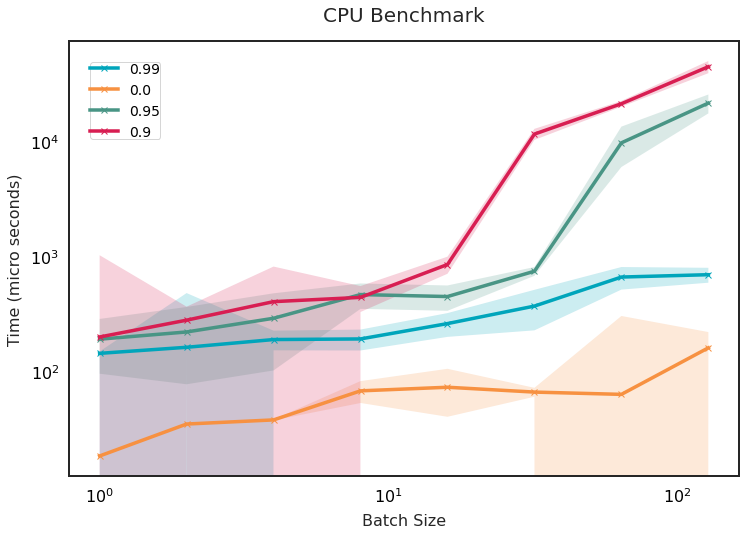

In [18]:
import re
import pandas as pd
import numpy as np
plt.style.use("../plt_plot_style.mplstyle")
data = {
    "sparsity": [],
    "batch_size": [],
    "num_features": [],
    "time": [],
    "std": []
}
for measurement in compare._results:
    desc = measurement.description
    sparsity = desc[-3:]
    if sparsity == "0.5":
        continue
    if desc == "Linear":
        data["sparsity"].append(0.0)
    else:
        data["sparsity"].append(float(desc[-3:]))
    batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
    data["batch_size"].append(int(batch))
    data["num_features"].append(int(num_features))
    data["time"].append(measurement.median*1e6)
    data["std"].append(np.std(measurement.times)*1e6)
df = pd.DataFrame(data)
df = df.sort_values(by="batch_size", ascending=True)
fig, ax = plt.subplots(figsize=(12,8))
df = df.loc[df["batch_size"]<=128]
for s in df["sparsity"].unique():
    df_slice = df.loc[df["sparsity"] == s]
    # df_slice = df_slice.groupby("batch_size").agg(mean_time=("time", "mean"), std_time=("time", "std")).reset_index()
    ax.plot(df_slice["batch_size"], df_slice["time"], label=s, marker="x")
    ax.fill_between(
        df_slice["batch_size"],
        df_slice["time"]+df_slice["std"],
        df_slice["time"]-df_slice["std"],
        alpha=0.2
    )
plt.legend()
plt.ylabel("Time (micro seconds)")
plt.xlabel("Batch Size")
plt.title(f"{result_type.upper()} Benchmark")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()
fig.savefig(f"{result_type}_benchmark.png", dpi=400, transparent=False)


In [5]:
df.loc[df["sparsity"]==0.99]

,sparsity,batch_size,num_features,time,std
3,0.99,1,65536,117.328959,48.746880
7,0.99,2,65536,130.656420,88.981153
11,0.99,4,65536,141.460787,118.561861
15,0.99,8,65536,207.564182,47.708308
19,0.99,16,65536,214.062759,94.602131
23,0.99,32,65536,276.586530,91.388248
27,0.99,64,65536,342.392096,461.597820
31,0.99,128,65536,522.159430,281.140604
35,0.99,256,65536,3162.252305,1076.738005
39,0.99,512,65536,5964.254402,2249.014333


In [6]:
for result in compare._results:
    if "0.99" in result.description:
        print(result.description)
        print(result.sub_label)
        print(result.times)
    

Linear Condensed @ sparsity 0.99
1      x 65536
[0.0002691541495732963, 0.00013465461088344455, 0.0001340355514548719, 0.0001345409592613578, 0.0001339767500758171, 0.00013362806988880037, 0.00013150752987712623, 0.0001342773507349193, 0.00013241336913779377, 0.00012117860140278936, 0.00011668854160234331, 0.00011654522037133574, 0.00011639663018286228, 0.00011788978008553386, 0.0001179684791713953, 0.00011663465993478894, 0.00011876504868268967, 0.0002766809891909361, 0.00011706321965903044, 0.00011654338100925088, 0.00011995511827990413, 0.00011653186986222863, 0.00011695852968841791, 0.00011701021110638977, 0.00011698225978761911, 0.00011670708889141679, 0.00011647725943475962, 0.00011660720920190216, 0.00011670064879581332, 0.00011679441900923849, 0.00011732553830370306, 0.00011677891016006469, 0.00011669386876747012, 0.00012070731027051807, 0.00012069751042872667, 0.00011647554114460945, 0.00011645606951788068, 0.00011658072005957365, 0.00011653576977550984, 0.00011657146969810129

In [7]:
compare._results[3]

Linear Condensed: 1      x 65536
Linear Condensed @ sparsity 0.95
setup: from __main__ import lc_benchmark
  Median: 140.97 us
  IQR:    33.35 us (138.21 to 171.55)
  30 measurements, 1000 runs per measurement, 48 threads
           This could indicate system fluctuation.

In [8]:
df

,sparsity,batch_size,num_features,time,std
0,0.00,1,65536,80.209539,15.716728
1,0.90,1,65536,189.092965,84.915476
2,0.95,1,65536,140.972674,72.696826
3,0.99,1,65536,117.328959,48.746880
4,0.00,2,65536,606.512359,160.527767
5,0.90,2,65536,195.293328,80.050482
6,0.95,2,65536,195.203793,52.355412
7,0.99,2,65536,130.656420,88.981153
11,0.99,4,65536,141.460787,118.561861
10,0.95,4,65536,192.790821,239.876874


In [9]:
df.loc[(df["sparsity"]=="Dense") & (df["batch_size"] == 1024)]["time"]

Series([], Name: time, dtype: float64)

In [10]:
df["batch_size"].value_counts()

1      4
2      4
4      4
8      4
16     4
32     4
64     4
128    4
256    4
512    4
Name: batch_size, dtype: int64

In [11]:
compare._results[0].

SyntaxError: invalid syntax (1424521647.py, line 1)

In [ ]:
print(compare)

[--------------------------------------------------------------------------------- Linear Condensed --------------------------------------------------------------------------------]
                                     |  Linear Condensed @ sparsity 0.5  |  Linear Condensed @ sparsity 0.9  |  Linear Condensed @ sparsity 0.95  |  Linear Condensed @ sparsity 0.99
1 threads: --------------------------------------------------------------------------------------------------------------------------------------------------------------------------
      256    x 2582                  |               160.2               |               134.3               |               131.7                |               129.9              
      2      x 85   (discontiguous)  |               130.4               |               128.2               |               128.5                |                91.7              
      1      x 8589                  |               215.5               |               1

In [ ]:
df_slice["time"]

43     125.581254
133    121.344458
248    120.485745
58     128.155211
163    120.363428
13     129.685441
78     131.737106
158    123.574821
8       91.730111
83      87.901600
18     127.311997
38      92.142595
168    123.746805
193    123.835034
128    123.356488
28     128.143633
243    124.839980
173    125.319584
113     87.753279
148    122.615424
23     127.784553
238    126.868860
183    123.556189
33     132.517780
153    125.470408
218    124.256704
178    127.197951
68     133.413050
203    124.092071
103    125.065685
108    125.888155
118    124.684060
123    125.746259
198     88.613903
98     125.294512
53     129.545197
228    126.374462
73     129.861717
138    124.285895
93     125.394706
88     125.481698
48     129.170376
223    126.410716
3      129.924004
233    125.708434
143    124.735837
188    126.583376
208    124.007753
213    125.391100
63     130.498093
Name: time, dtype: float64

In [ ]:
df_slice["std"]

43     1285.511933
133     784.327621
248    1355.681002
58     1013.180325
163     404.625006
13      370.533930
78     4043.948875
158    1163.177724
8      3762.955079
83     5974.215354
18      368.062653
38     1267.570071
168     636.280135
193    1151.662413
128     962.014436
28     1141.559017
243     261.697099
173    1066.159259
113    1408.412354
148     312.935283
23      248.021783
238     406.244946
183     419.612925
33     1350.155207
153     929.381873
218     433.069983
178     348.271148
68      403.155041
203     510.653930
103     873.101047
108     275.391877
118     437.017708
123     128.276015
198    3104.252042
98     1082.814891
53      307.604050
228    1239.075275
73      384.923156
138     392.923542
93      579.522034
88      459.873980
48      504.069956
223     109.277376
3       556.904481
233     721.369713
143     382.393102
188    2149.580412
208     640.273906
213    2396.318858
63      940.665198
Name: std, dtype: float64

In [ ]:
compare._results[0].description

'Linear Condensed @ sparsity 0.9'

In [ ]:
for tensors, tensor_params, params in fuzzer.take(1):
    break

In [ ]:
tensors["x"].shape

torch.Size([256, 2582])

In [ ]:
torch.device("cuda:0")

device(type='cuda', index=0)

In [ ]:
lc_params=dict(
    in_features= tensors["x"].shape[1],
    out_features=10,
    bias=True,
    input_len=tensors["x"].shape[1],
    fan_out_const=True,
    device=torch.device("cuda:0"),
    dtype=torch.float32

)
lc = LinearCondensed(**lc_params)
lc

LinearCondensed(in_features=2582, out_features=10, bias=True)

In [ ]:
lc._parameters["weight"]

Parameter containing:
tensor([[-0.0120,  0.0014, -0.0042,  ..., -0.0052,  0.0077, -0.0084],
        [ 0.0131,  0.0196,  0.0184,  ..., -0.0040,  0.0142,  0.0021],
        [ 0.0051, -0.0187,  0.0127,  ..., -0.0091, -0.0020, -0.0009],
        ...,
        [ 0.0124,  0.0086, -0.0120,  ..., -0.0111,  0.0088, -0.0119],
        [ 0.0175, -0.0137, -0.0091,  ...,  0.0066, -0.0138, -0.0105],
        [-0.0052,  0.0181,  0.0081,  ...,  0.0069, -0.0090,  0.0097]],
       device='cuda:0', requires_grad=True)

In [ ]:
tensor_params

{'x': {'numel': 186325,
  'order': array([0, 1]),
  'steps': (1, 1),
  'is_contiguous': True,
  'dtype': 'torch.float32'}}

In [ ]:
params

{'k0': 725, 'k1': 257}

In [ ]:
tensors["x"].shape

torch.Size([725, 257])

In [ ]:
results = []
for tensors, tensor_params, params in fuzzer.take(10):
    # description is the column label
    sub_label=f"{params['k0']:<6} x {params['k1']:<4} {'' if tensor_params['x']['is_contiguous'] else '(discontiguous)'}"
    results.append(benchmark.Timer(
        stmt='batched_dot_mul_sum(x, x)',
        setup='from __main__ import batched_dot_mul_sum',
        globals=tensors,
        label='Batched dot',
        sub_label=sub_label,
        description='mul/sum',
    ).blocked_autorange(min_run_time=1))
    results.append(benchmark.Timer(
        stmt='batched_dot_bmm(x, x)',
        setup='from __main__ import batched_dot_bmm',
        globals=tensors,
        label='Batched dot',
        sub_label=sub_label,
        description='bmm',
    ).blocked_autorange(min_run_time=1))

compare = benchmark.Compare(results)
compare.trim_significant_figures()
compare.print()

ImportError: cannot import name 'batched_dot_mul_sum' from '__main__' (unknown location)